In [217]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim import corpora, models, similarities, matutils
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from textblob import TextBlob

import string
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

## Setup

### Import books 

In [81]:
all_books = pd.read_pickle('data/allbooks.pkl')

In [82]:
all_books

,chapter_title,book_title,cumulative_chapter_number,text
0,Dragonmount,The Eye of the world,1,the palace still shook occasionally as the ear...
1,An Empty Road,The Eye of the world,2,the wheel of time turns and ages come and pass...
2,Strangers,The Eye of the world,3,when rand and mat carried the first barrels th...
3,The Peddler,The Eye of the world,4,clusters of pots clattered and banged as s wag...
4,The Gleeman,The Eye of the world,5,the door of the inn banged shut behind the whi...
...,...,...,...,...
672,To Awaken,A Memory of Light,673,rand broke free from the darkness and entered ...
673,Watching the Flow Writhe,A Memory of Light,674,she fought it off but barely the forsaken lean...
674,A Brilliant Lance,A Memory of Light,675,so many dead hundreds of thousands of men and ...
675,Light and Shadow,A Memory of Light,676,beneath that was only emptiness in the wolf dr...


In [108]:
sw = stopwords.words('english')
sw = [w.translate(str.maketrans('', '', string.punctuation)) for w in sw]
sw = list(set(sw))
sw.extend(['said','did','like', 'woman', 'man'])

### Make TF-IDF Vectorizer to start with 

In [132]:
vectorizer1 = TfidfVectorizer(ngram_range=(1, 1),  stop_words=sw)

doc_word=vectorizer1.fit_transform(all_books['text'])
doc_word_df=pd.DataFrame(doc_word.toarray(), columns=vectorizer1.get_feature_names())


In [134]:
doc_word_df

,aaaaaaaaaaaaaaaaah,aaaaaaah,aaaaah,aaaah,aaagh,aaah,aagh,aah,aahed,aahing,...,zipped,zipping,zither,zithers,zomara,zomaran,zone,zorelle,zty,zushi
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.022917,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
672,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
673,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
674,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
675,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Testing different topic modeling methods

### NMF

In [135]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [136]:
nmf_model1 = NMF(20)
doc_topic_nmf = nmf_model1.fit_transform(doc_word)

/Users/Nathaniel/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


In [137]:
display_topics(nmf_model1, vectorizer1.get_feature_names(), 10)


Topic  0
could, would, one, even, lord, men, might, back, eyes, made

Topic  1
perrin, gaul, faile, wolves, elyas, hopper, slayer, wolf, perrins, galad

Topic  2
mat, thom, talmanes, bloody, thorn, dice, noal, olver, one, would

Topic  3
nynaeve, elayne, could, one, nynaeves, moghedien, thom, juilin, would, know

Topic  4
egwene, amyrlin, elaida, tower, sheriam, egwenes, silviana, would, one, ajah

Topic  5
moiraine, lan, rand, one, sedai, aes, warder, could, even, zarine

Topic  6
aviendha, aiel, amys, wise, rhuarc, would, bair, ones, rand, could

Topic  7
rand, min, lews, therin, bashere, dragon, taim, one, rands, maidens

Topic  8
elayne, birgitte, aviendha, dyelin, would, merilille, norry, vandene, elaynes, one

Topic  9
ituralde, trollocs, hed, lan, battle, would, one, army, seanchan, battlefield

Topic  10
ingtar, hurin, rand, horn, selene, lord, fain, loial, sniffer, uno

Topic  11
cadsuane, min, harine, sorilea, merise, semirhage, sarene, althor, shalon, cadsuanes

Topic  12
s

### sklearn LDA

In [138]:
lda_model1 = LatentDirichletAllocation(n_components=20)
doc_topic_lda = lda_model1.fit_transform(doc_word)


In [139]:
display_topics(lda_model1, vectorizer1.get_feature_names(), 10)


Topic  0
lian, ellisor, nieda, marline, dairaine, alakir, ailhuin, hatch, deathgates, yoeli

Topic  1
faile, berelain, bashere, morgase, talmanes, ituralde, fain, dyelin, melaine, aybara

Topic  2
aleis, ailhuin, tumad, dav, elam, maryim, guenna, cuale, andaya, cockades

Topic  3
almen, naeff, jonai, coumin, rajabi, samon, adan, mallia, leya, charn

Topic  4
simion, jenn, bartim, jeordam, melanril, rhodric, mandein, gholams, maigran, charlin

Topic  5
shielyn, tema, elsie, matherin, joiyas, ros, slingmen, shatayan, troilocs, aedmun

Topic  6
mandevwin, silvie, tharne, redveils, tammuz, berisha, corana, jisao, covarla, nem

Topic  7
guybon, jorin, norley, wavedancer, marah, akarrin, mishima, faloun, pevin, lopar

Topic  8
panarchs, rendra, conail, catalyn, perival, morsa, nieda, monaelle, malenarin, quillin

Topic  9
caraline, nandera, kiruna, edorion, coine, demira, aleis, reimon, meresin, con

Topic  10
habor, katerine, talene, sleete, iralin, luci, zerah, kireyin, padra, oncala

Top

###  Truncated SVD

In [140]:
TSVD_model1 = TruncatedSVD(n_components=20)
doc_topic_TSVD = TSVD_model1.fit_transform(doc_word)
display_topics(TSVD_model1, vectorizer1.get_feature_names(), 10)


Topic  0
could, would, one, rand, egwene, perrin, nynaeve, mat, elayne, back

Topic  1
perrin, faile, rand, loial, gaul, trollocs, lord, wolves, berelain, hopper

Topic  2
mat, rand, thom, tuon, bloody, dice, talmanes, noal, hurin, olver

Topic  3
elayne, perrin, mat, birgitte, nynaeve, faile, thom, juilin, galad, tuon

Topic  4
mat, egwene, siuan, amyrlin, tuon, bryne, gawyn, sheriam, elaida, lelaine

Topic  5
nynaeve, loial, moiraine, perrin, egwene, lan, rand, hurin, ingtar, thom

Topic  6
aviendha, egwene, amys, aiel, elayne, wise, rhuarc, mat, moiraine, bair

Topic  7
gawyn, cadsuane, androl, min, hed, elayne, trollocs, ituralde, galad, rand

Topic  8
nynaeve, cadsuane, min, egwene, mat, faile, amys, wise, sorilea, perrin

Topic  9
mat, min, elayne, rand, faile, cadsuane, siuan, loial, verin, perrin

Topic  10
hurin, egwene, ingtar, tuon, seanchan, verin, egeanin, rand, faile, damane

Topic  11
gawyn, rand, galad, bryne, morgase, thom, nynaeve, faile, min, tallanvor

Topic  12
an

### gensim LDA 

In [141]:
corpus = matutils.Sparse2Corpus(doc_word.transpose())
id2word = dict((v, k) for k, v in vectorizer1.vocabulary_.items())
gensim_lda = models.LdaModel(corpus=corpus, num_topics=10, id2word=id2word, passes=5)


In [142]:
gensim_lda.print_topics()


[(0,
  '0.000*"simion" + 0.000*"one" + 0.000*"could" + 0.000*"perrin" + 0.000*"would" + 0.000*"rand" + 0.000*"mat" + 0.000*"egwene" + 0.000*"even" + 0.000*"elayne"'),
 (1,
  '0.000*"hake" + 0.000*"rand" + 0.000*"would" + 0.000*"could" + 0.000*"one" + 0.000*"mat" + 0.000*"strom" + 0.000*"elayne" + 0.000*"back" + 0.000*"nynaeve"'),
 (2,
  '0.004*"would" + 0.004*"could" + 0.004*"one" + 0.003*"rand" + 0.003*"perrin" + 0.002*"egwene" + 0.002*"mat" + 0.002*"nynaeve" + 0.002*"elayne" + 0.002*"back"'),
 (3,
  '0.000*"one" + 0.000*"could" + 0.000*"would" + 0.000*"perrin" + 0.000*"caddar" + 0.000*"egwene" + 0.000*"meidani" + 0.000*"rand" + 0.000*"nynaeve" + 0.000*"rhiale"'),
 (4,
  '0.000*"lyrelle" + 0.000*"dimana" + 0.000*"kaisea" + 0.000*"would" + 0.000*"marille" + 0.000*"one" + 0.000*"could" + 0.000*"perrin" + 0.000*"rand" + 0.000*"faile"'),
 (5,
  '0.000*"egwene" + 0.000*"renald" + 0.000*"would" + 0.000*"nynaeve" + 0.000*"could" + 0.000*"one" + 0.000*"elayne" + 0.000*"rand" + 0.000*"back" + 

Looks like NMF is the best going to try to improve those topics

## Adjustments to NMF pipeline

### CountVectorizer vs TidfVectorizer 

In [144]:
CV = CountVectorizer(ngram_range=(1, 1),  stop_words=sw)
doc_word=CV.fit_transform(all_books['text'])
doc_word_df=pd.DataFrame(doc_word.toarray(), columns=CV.get_feature_names())
nmf_model = NMF(20)
doc_topic = nmf_model.fit_transform(doc_word)
display_topics(nmf_model, CV.get_feature_names(), 10)

/Users/Nathaniel/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "



Topic  0
could, would, even, one, might, know, never, way, thought, knew

Topic  1
one, would, could, back, demandred, trollocs, men, mat, light, battle

Topic  2
rand, rands, dragon, back, looked, lews, loial, hurin, sword, therin

Topic  3
perrin, faile, two, men, wolves, lord, back, gaul, wolf, rivers

Topic  4
egwene, one, amyrlin, tower, egwenes, would, white, elaida, know, well

Topic  5
mat, thom, bloody, back, one, well, would, going, get, dice

Topic  6
nynaeve, one, back, elayne, nynaeves, way, eyes, could, know, moghedien

Topic  7
elayne, birgitte, aviendha, would, one, elaynes, well, dyelin, know, andor

Topic  8
sedai, aes, could, would, one, even, two, might, though, well

Topic  9
aiel, aviendha, wise, ones, one, would, amys, could, rhuarc, rand

Topic  10
would, could, one, galad, hed, men, asked, ituralde, light, time

Topic  11
talmanes, one, men, androl, could, would, back, us, city, hed

Topic  12
siuan, leane, bryne, amyrlin, lelaine, sheriam, hall, tower, myrell

/Users/Nathaniel/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


In [145]:
Tfidf = TfidfVectorizer(ngram_range=(1, 1),  stop_words=sw)
doc_word=Tfidf.fit_transform(all_books['text'])
doc_word_df=pd.DataFrame(doc_word.toarray(), columns=Tfidf.get_feature_names())
nmf_model = NMF(20)
doc_topic = nmf_model.fit_transform(doc_word)
display_topics(nmf_model, Tfidf.get_feature_names(), 10)

/Users/Nathaniel/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "



Topic  0
could, would, one, even, might, back, men, lord, eyes, though

Topic  1
perrin, faile, gaul, wolves, elyas, hopper, slayer, wolf, perrins, loial

Topic  2
mat, thom, talmanes, bloody, thorn, dice, noal, olver, one, would

Topic  3
nynaeve, elayne, could, one, nynaeves, moghedien, thom, juilin, would, know

Topic  4
egwene, amyrlin, elaida, tower, sheriam, egwenes, silviana, would, one, ajah

Topic  5
moiraine, lan, one, rand, sedai, aes, warder, zarine, could, loial

Topic  6
aviendha, aiel, amys, wise, rhuarc, would, rand, bair, ones, could

Topic  7
rand, min, lews, therin, bashere, dragon, taim, rands, maidens, one

Topic  8
elayne, birgitte, aviendha, dyelin, would, merilille, norry, vandene, elaynes, alise

Topic  9
ituralde, trollocs, hed, one, lan, battle, would, could, army, battlefield

Topic  10
loial, hurin, rand, ingtar, selene, ogier, horn, lord, fain, could

Topic  11
cadsuane, min, harine, sorilea, merise, semirhage, sarene, shalon, althor, cadsuanes

Topic  12

Neither looks too bad, but the topics are more immediately obvious to me with TfidfVectorizer, so I will continue on with that. 

### Other parameters 

#### min/max df

The first topic has common words, so we should try to set max_df to a number lower than 1 to try to toss them out. Might as well also set min to get rid of 1 offs

In [150]:
vectorizer = TfidfVectorizer(ngram_range=(1, 1),  stop_words=sw, max_df = .95, min_df = 2)
doc_word=vectorizer.fit_transform(all_books['text'])
doc_word_df=pd.DataFrame(doc_word.toarray(), columns=vectorizer.get_feature_names())
nmf_model = NMF(20, max_iter = 1000)
doc_topic = nmf_model.fit_transform(doc_word)
display_topics(nmf_model, vectorizer.get_feature_names(), 10)



Topic  0
rand, lews, bashere, therin, dragon, taim, maidens, saidin, aiel, lord

Topic  1
perrin, gaul, wolves, faile, elyas, hopper, slayer, wolf, perrins, galad

Topic  2
mat, thom, bloody, talmanes, thorn, dice, olver, noal, mats, vanin

Topic  3
nynaeve, elayne, moghedien, nynaeves, thom, juilin, sedai, aes, liandrin, us

Topic  4
egwene, amyrlin, tower, elaida, sheriam, egwenes, silviana, ajah, sitters, novices

Topic  5
moiraine, lan, sedai, aes, rand, warder, zarine, loial, moiraines, perrin

Topic  6
aviendha, aiel, amys, wise, rhuarc, ones, bair, melaine, rhuidean, rand

Topic  7
ituralde, trollocs, hed, lan, galad, battle, army, seanchan, battlefield, fight

Topic  8
elayne, birgitte, aviendha, dyelin, merilille, norry, vandene, elaynes, alise, reanne

Topic  9
tuon, egeanin, seanchan, selucia, luca, damane, suldam, domon, joline, suroth

Topic  10
loial, hurin, rand, ingtar, selene, ogier, horn, lord, fain, stedding

Topic  11
cadsuane, harine, sorilea, merise, semirhage, s

That actually worked super well, all these topics look pretty good now!

#### Try setting ngram range to a higher number 

In [151]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2),  stop_words=sw, max_df = .95, min_df = 2)
doc_word=vectorizer.fit_transform(all_books['text'])
doc_word_df=pd.DataFrame(doc_word.toarray(), columns=vectorizer.get_feature_names())
nmf_model = NMF(20, max_iter = 1000)
doc_topic = nmf_model.fit_transform(doc_word)
display_topics(nmf_model, vectorizer.get_feature_names(), 10)



Topic  0
rand, lews, therin, lews therin, bashere, dragon, taim, lord dragon, saidin, maidens

Topic  1
perrin, faile, gaul, elyas, wolves, slayer, hopper, wolf, perrins, berelain

Topic  2
mat, thom, talmanes, bloody, thorn, noal, dice, olver, mats, gholam

Topic  3
nynaeve, elayne, moghedien, thom, nynaeves, juilin, sedai, aes, aes sedai, birgitte

Topic  4
egwene, amyrlin, tower, elaida, sheriam, egwenes, silviana, verin, meidani, ajah

Topic  5
moiraine, lan, rand, sedai, loial, aes, aes sedai, zarine, warder, perrin

Topic  6
aviendha, amys, aiel, wise, wise ones, rhuarc, bair, ones, rand, melaine

Topic  7
ituralde, trollocs, hed, lan, fortuona, battle, seanchan, army, battlefield, fight

Topic  8
cadsuane, harine, sorilea, shalon, merise, semirhage, sarene, verin, althor, alanna

Topic  9
tuon, egeanin, selucia, seanchan, damane, luca, suldam, domon, joline, suroth

Topic  10
androl, pevara, emarin, taim, logain, nalaam, evin, dobser, jonneth, canler

Topic  11
loial, hurin, ra

Most of the topics are the same, but it does end up with some bigrams that I expect, like Lews Therin and Aes Sedai. I'll keep them in because I think they do add some good insight into the topics

### Getting rid of plurals

It's not that big of an issue but I do want to try getting rid of "plurals" because a lot of the time the topics have a character's name and the name with an s, which I assume is a the possessive form

The issue is that some words/names end in s, so I'll try to make exceptions for those

In [198]:
plural_exceptions = ['aes', 'lews']
def singularize_chapter(text, exceptions = plural_exceptions):
    tb = TextBlob(text)
    words = tb.words
    sing_list=[word if word in exceptions else word.singularize() for word in words]
    return ' '.join(sing_list)

In [202]:
all_books_singularized = all_books.copy()
all_books_singularized['text'] = all_books_singularized.progress_apply(lambda x: singularize_chapter(x['text']), axis=1)

  0%|          | 0/677 [00:00<?, ?it/s]

In [205]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2),  stop_words=sw, max_df = .95, min_df = 2)
doc_word=vectorizer.fit_transform(all_books_singularized['text'])
doc_word_df=pd.DataFrame(doc_word.toarray(), columns=vectorizer.get_feature_names())
nmf_model = NMF(20, max_iter = 1000)
doc_topic = nmf_model.fit_transform(doc_word)
display_topics(nmf_model, vectorizer.get_feature_names(), 10)


Topic  0
rand, bashere, lews, therin, lews therin, dragon, taim, lord, lord dragon, saidin

Topic  1
perrin, wolf, slayer, hopper, galad, ituralde, gaul, byar, young bull, hed

Topic  2
mat, talmane, bloody, noal, thorn, olver, gholam, dice, vanin, nalesean

Topic  3
nynaeve, elayne, moghedien, juilin, sedai, aes, aes sedai, liandrin, birgitte, nynaeve wa

Topic  4
egwene, amyrlin, sheriam, elaida, tower, verin, silviana, novice, ajah, sitter

Topic  5
moiraine, lan, rand, perrin, trolloc, loial, sedai, warder, aes, aes sedai

Topic  6
aviendha, wise one, aiel, amy, wise, rhuarc, bair, rand, melaine, maiden

Topic  7
gawyn, bryne, sleete, galad, egwene, hed, elayne, soldier, trolloc, ituralde

Topic  8
elayne, birgitte, aviendha, dyelin, merilille, norry, arymilla, vandene, alise, reanne

Topic  9
tuon, egeanin, selucium, seanchan, luca, damane, suldam, domon, joline, suroth

Topic  10
siuan, lelaine, leane, sheriam, bryne, romanda, myrelle, amyrlin, sedai, aes

Topic  11
cadsuane, ha

That seemed to get rid of the spurious repeats so I'll stick with it, but not a huge improvement

### Different component numbers 

In [207]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2),  stop_words=sw, max_df = .95, min_df = 2)
doc_word=vectorizer.fit_transform(all_books_singularized['text'])
doc_word_df=pd.DataFrame(doc_word.toarray(), columns=vectorizer.get_feature_names())

In [209]:
for num in [10,15,20,25,30]:
    print('\n',num)
    nmf_model = NMF(num, max_iter = 1000)
    doc_topic = nmf_model.fit_transform(doc_word)
    display_topics(nmf_model, vectorizer.get_feature_names(), 10)


 10

Topic  0
cadsuane, min, rand, therin, lews, lews therin, alanna, merana, semirhage, bashere

Topic  1
perrin, faile, wolf, berelain, gaul, hopper, elya, slayer, masema, galad

Topic  2
mat, thom, talmane, bloody, noal, thorn, olver, dice, gholam, rand

Topic  3
nynaeve, elayne, egwene, moghedien, thom, juilin, sedai, liandrin, aes, aes sedai

Topic  4
egwene, siuan, amyrlin, elaida, sheriam, tower, sedai, lelaine, romanda, sitter

Topic  5
rand, loial, moiraine, lan, hurin, ingtar, trolloc, ogier, perrin, tam

Topic  6
aviendha, aiel, rand, wise one, wise, amy, rhuarc, maiden, egwene, bair

Topic  7
androl, gawyn, trolloc, pevara, ituralde, bryne, hed, gateway, taim, galad

Topic  8
elayne, birgitte, aviendha, dyelin, merilille, norry, vandene, arymilla, reanne, alise

Topic  9
tuon, egeanin, seanchan, selucium, luca, damane, suldam, domon, suroth, joline

 15

Topic  0
rand, min, therin, lews, lews therin, bashere, dragon, lord, taim, maiden

Topic  1
perrin, faile, wolf, gaul, 

morgase, tallanvor, gill, gaebril, lini, queen, niall, master gill, balwer, lord

Topic  28
aiel, rhuarc, rand, couladin, wise one, chief, wise, clan, amy, rhuidean

Topic  29
egeanin, domon, seanchan, suldam, damane, bethamin, suroth, renna, luca, panarch


Kind of amazing how there are 30+ topics with good separability, there doesn't seem to bee too much repeat. Going to go with 20 though because the plotlines described with 25+ are getting a little too specific. 

## Preliminary visualization 

In [261]:
last_chaps= [54, 105, 162, 220, 277, 334, 376, 408, 444, 476, 515, 567, 626]

starts_ends= [0,54, 105, 162, 220, 277, 334, 376, 408, 444, 476, 515, 567, 626, 677]
starts = [0,54, 105, 162, 220, 277, 334, 376, 408, 444, 476, 515, 567, 626]
tick_locations = []
for i in range(len(starts_ends)-1):
    ave = (starts_ends[i] + starts_ends[i+1])//2
    tick_locations.append(ave)
print(tick_locations)    

titles = ['The Eye of the World',
 'The Great Hunt',
 'The Dragon Reborn',
 'The Shadow Rising',
 'The Fires of Heaven',
 'Lord of Chaos',
 'A Crown of Swords',
 'The Path of Daggers',
 'Winter\'s Heart',
 'Crossroads of Twilight',
 'Knife of Dreams',
 'The Gathering Storm',
 'Towers of Midnight',
 'A Memory of Light']

[27, 79, 133, 191, 248, 305, 355, 392, 426, 460, 495, 541, 596, 651]


In [247]:
all_books_nosw_singularized = pd.read_pickle('data/allbooks_sing_nosw.pkl')
vectorizer = TfidfVectorizer(ngram_range=(1, 2),  stop_words=sw, max_df=.95, min_df=2)
doc_word = vectorizer.fit_transform(all_books_nosw_singularized['text'])
nmf_model = NMF(20, max_iter=1000)
doc_topic = nmf_model.fit_transform(doc_word)
display_topics(nmf_model, vectorizer.get_feature_names(), 10)


Topic  0
rand, therin, lews, lews therin, bashere, dragon, taim, lord, lord dragon, maiden

Topic  1
perrin, faile, wolf, gaul, elya, slayer, berelain, hopper, galad, masema

Topic  2
mat, talmanes, bloody, noal, thorn, olver, gholam, dice, vanin, nalesean

Topic  3
nynaeve, elayne, moghedien, juilin, sedai, aes, aes sedai, liandrin, birgitte, egeanin

Topic  4
egwene, amyrlin, sheriam, tower, elaida, verin, silviana, novice, ajah, sitter

Topic  5
moiraine, lan, rand, sedai, loial, aes, aes sedai, warder, perrin, trolloc

Topic  6
aviendha, wise one, aiel, amy, wise, rhuarc, bair, rand, melaine, maiden

Topic  7
gawyn, bryne, sleete, galad, egwene, elayne, hed, tower, sedai, aes

Topic  8
elayne, birgitte, aviendha, dyelin, merilille, norry, vandene, arymilla, reanne, alise

Topic  9
tuon, egeanin, selucium, seanchan, luca, damane, suldam, joline, domon, suroth

Topic  10
siuan, lelaine, sheriam, leane, bryne, romanda, myrelle, sedai, amyrlin, aes

Topic  11
cadsuane, harine, shalon,

In [248]:
topics = ['Rand', 'Perrin', 'Mat', 'Nynaeve', 'Egwene', 'Moiraine', 'Aiel', 'Gawyn', 'Elayne', 'Seanchan', 'Siuan',
         'Cadsuane politics', 'Black Tower', 'White Tower politics', 'Horn of Valere', 'Faile Kidnapping', 'Min',
         'Last Battle', 'Emond\'s Field','Thom']

In [249]:
viz_df = pd.DataFrame(doc_topic, columns = topics )

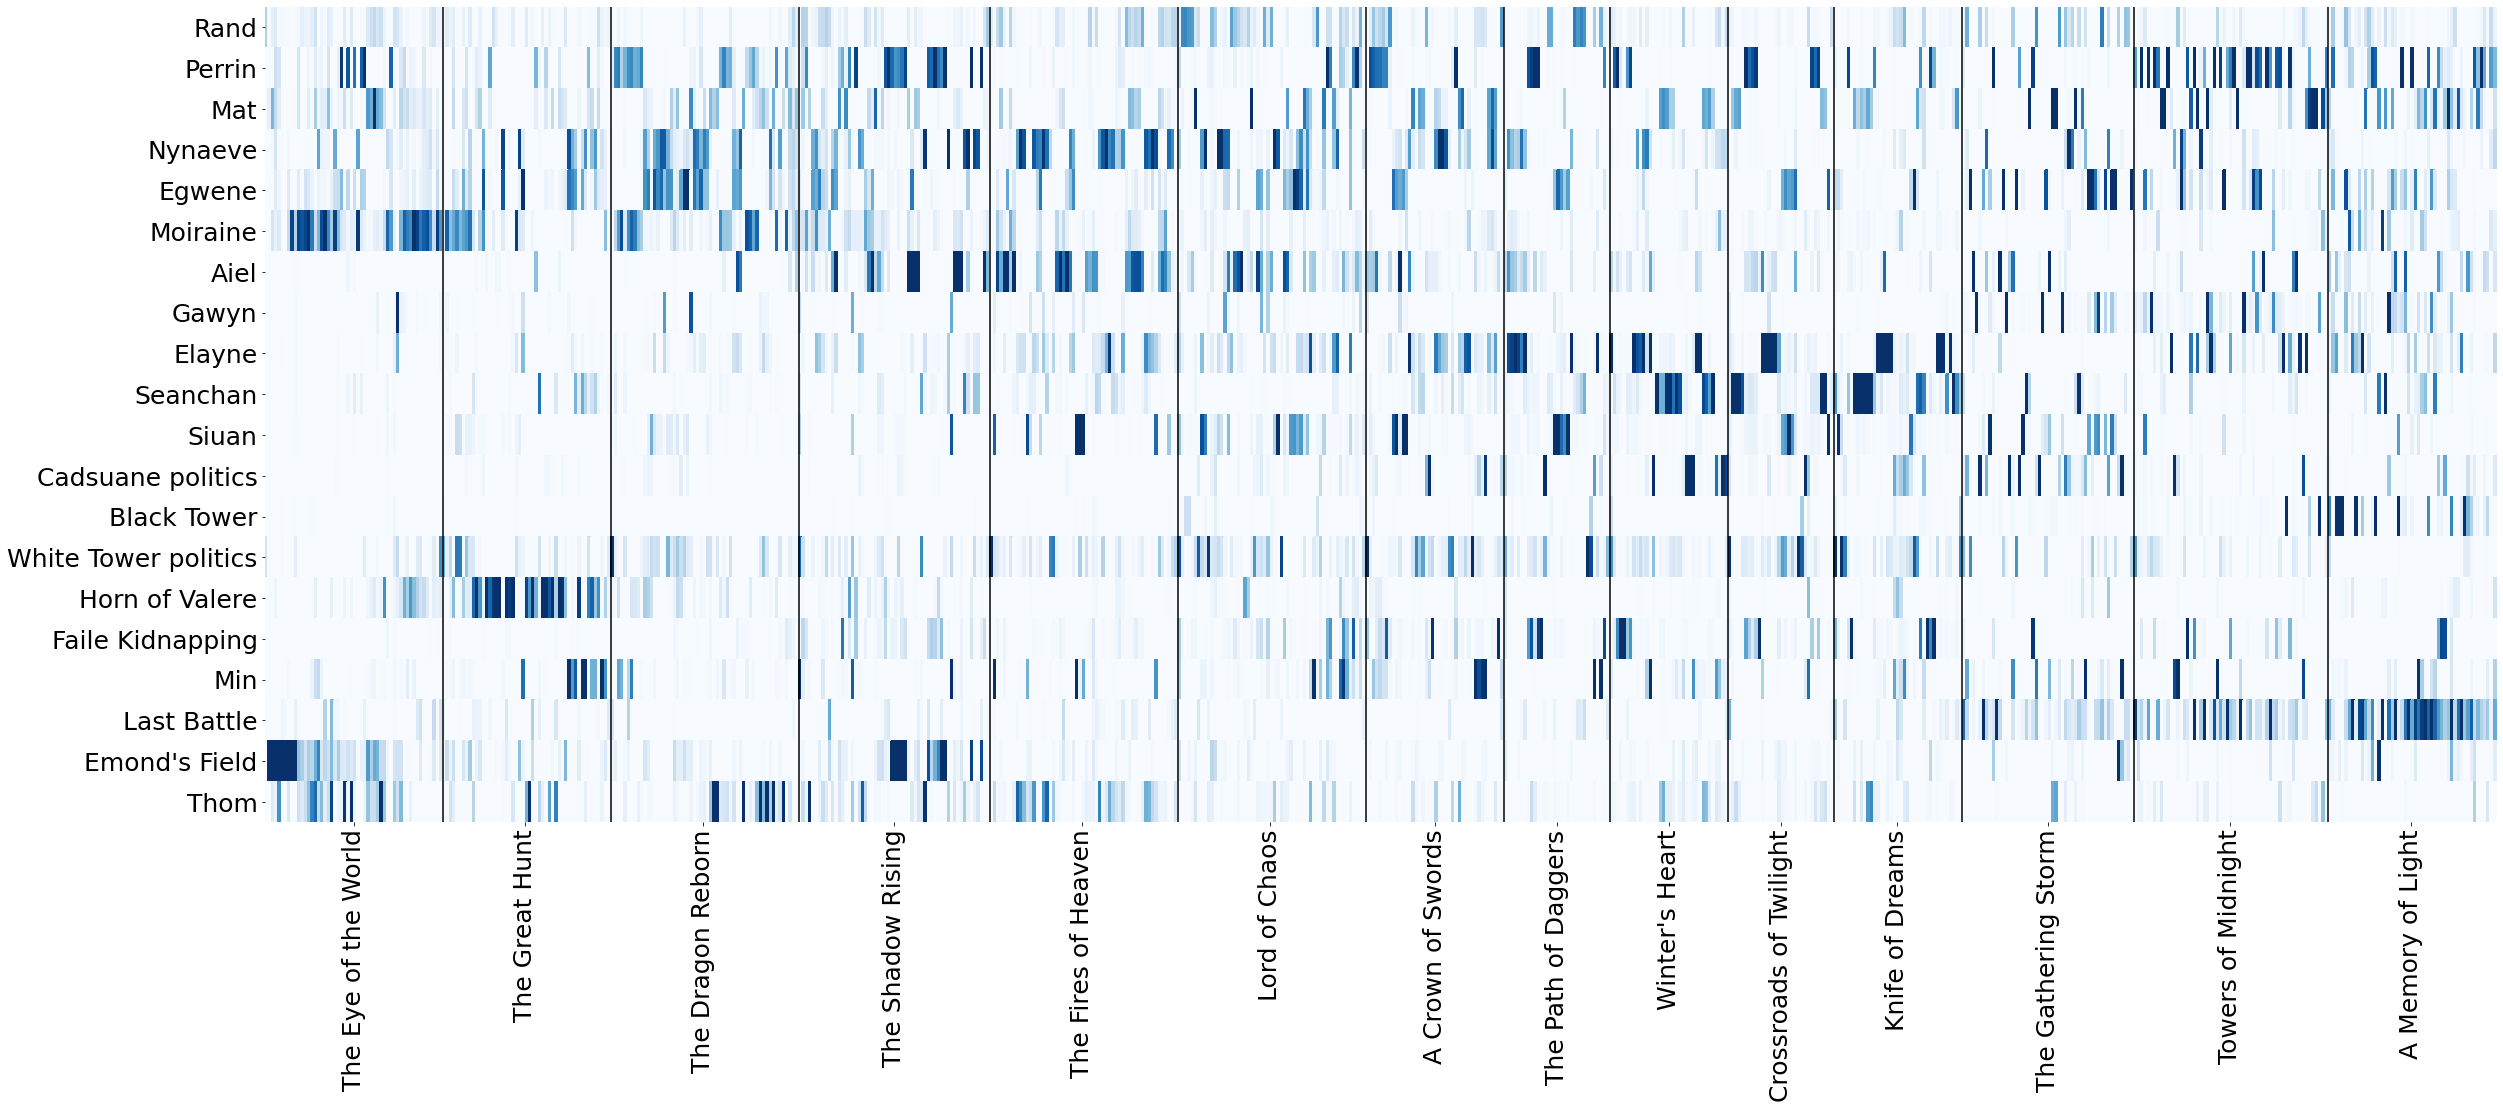

In [266]:

plt.figure(figsize=(40,15))
sns.heatmap(data = viz_df.T, cmap='Blues', cbar=False, robust=True)
plt.yticks(fontsize=25)
plt.xticks(ticks = tick_locations, labels = titles, fontsize = 25, )
plt.vlines(last_chaps, 0 ,25, color = 'black')
plt.show()